<a href="https://colab.research.google.com/github/Anshuman776/Deep-Learning-Projects-/blob/main/Autoencoders_Xray_images_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense,Conv2D, MaxPooling2D,MaxPool2D , UpSampling2D,Flatten ,Input
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls -F '/content/drive/MyDrive/Datasets/chest_xray/'

ls: cannot access '/content/drive/MyDrive/Datasets/chest_xray/': No such file or directory


In [5]:
# loading the dataset
# image size
img_size = 100

# data paths

traindatasetPath ="/content/drive/MyDrive/Datasets /chest_xray/train"
testDatasetPath="/content/drive/MyDrive/Datasets /chest_xray/test"
valDatasetPath="/content/drive/MyDrive/Datasets /chest_xray/val"

Training Data

In [6]:
training_data=[]
def create_training_data():
    categories = ["NORMAL", "PNEUMONIA"]
    for category in categories:
        path = os.path.join(traindatasetPath, category)
        class_num = categories.index(category) # 0 for NORMAL, 1 for PNEUMONIA
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img_array is None:
                    print(f'Warning: Could not read image {img_name} from {category}. Skipping.')
                    continue

                img_array = img_array / 255.0 # Normalize to 0-1
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_data.append([new_array, class_num])
            except Exception as e:
                print(f'Error occurred with {img_name} in {category}: {e}')

    print('Training data created. Total images: ', len(training_data))

In [7]:
create_training_data()

Training data created. Total images:  5226


In [8]:
testing_data=[]
def create_testing_data():
    categories = ["NORMAL", "PNEUMONIA"]
    for category in categories:
        path = os.path.join(testDatasetPath, category)
        class_num = categories.index(category) # 0 for NORMAL, 1 for PNEUMONIA
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img_array is None:
                    print(f'Warning: Could not read image {img_name} from {category}. Skipping.')
                    continue

                img_array = img_array / 255.0 # Normalize to 0-1
                new_array = cv2.resize(img_array, (img_size, img_size))
                testing_data.append([new_array, class_num])
            except Exception as e:
                print(f'Error occurred with {img_name} in {category}: {e}')

    print('Testing data created. Total images: ', len(testing_data))

In [9]:
create_testing_data()

Testing data created. Total images:  624


In [10]:
validation_data=[]
def create_validation_data():
    categories = ["NORMAL", "PNEUMONIA"]
    for category in categories:
        path = os.path.join(valDatasetPath, category)
        class_num = categories.index(category) # 0 for NORMAL, 1 for PNEUMONIA
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img_array is None:
                    print(f'Warning: Could not read image {img_name} from {category}. Skipping.')
                    continue

                img_array = img_array / 255.0 # Normalize to 0-1
                new_array = cv2.resize(img_array, (img_size, img_size))
                validation_data.append([new_array, class_num])
            except Exception as e:
                print(f'Error occurred with {img_name} in {category}: {e}')

    print('Validation data created. Total images: ', len(validation_data))

In [11]:
create_validation_data()

Validation data created. Total images:  16


prepare the data - converting to numpy array and reshaping

In [12]:
# separating images and labels
x_train = np.array([data[0] for data in training_data])
y_train = np.array([data[1] for data in training_data])

x_test = np.array([data[0] for data in testing_data])
y_test = np.array([data[1] for data in testing_data])

x_val = np.array([data[0] for data in validation_data])
y_val = np.array([data[1] for data in validation_data])

# Reshaping for CNN input (adding a channel dimension)
x_train = x_train.reshape(-1, img_size, img_size, 1)
x_test = x_test.reshape(-1, img_size, img_size, 1)
x_val = x_val.reshape(-1, img_size, img_size, 1)

**Visualize the Data**

In [13]:
#This function will take the name of the dataset and the image index as input and display the image
def visualize(dataset,index):
  new_array=cv2.resize(dataset[index][0],(img_size,img_size))
  plt.imshow(new_array,cmap='gray')
  plt.show()

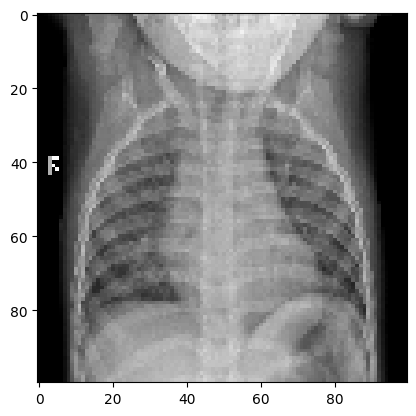

In [14]:
visualize(training_data,3)

In [15]:
def create_autoencoder():

    input_img = Input(shape=(100,100,1), name='image_input')

    #Encoder
    e1 = Conv2D(100, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    e2 = MaxPooling2D((2,2), padding='same', name='pool1')(e1)
    e3 = Conv2D(100, (3,3), activation='relu', padding='same', name='Conv2')(e2)
    e4 = MaxPooling2D((2,2), padding='same', name='pool2')(e3)

    #Decoder
    d1 = Conv2D(100, (3,3), activation='relu', padding='same', name='Conv3')(e4)
    d2 = UpSampling2D((2,2), name='upsample1')(d1)
    d3 = Conv2D(100, (3,3), activation='relu', padding='same', name='Conv4')(d2)
    d4 = UpSampling2D((2,2), name='upsample2')(d3)
    d5 = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(d4)

    #Model
    autoencoder = Model(inputs=input_img, outputs=d5)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    autoencoder.summary()

    return autoencoder

In [16]:
autoencoder = create_autoencoder()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 100, 100, 100)  │         1,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 50, 50, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 50, 50, 100)    │        90,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 25, 25, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 25, 25, 100)    │        90,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsample1 (UpSampling2D)        │ (None, 50, 50, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 50, 50, 100)    │        90,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsample2 (UpSampling2D)        │ (None, 100, 100, 100)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5 (Conv2D)                  │ (None, 100, 100, 1)    │           901 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272,201 (1.04 MB)

 Trainable params: 272,201 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
#Using GPU for training.


early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
ae_model = autoencoder.fit(x_train, x_train, epochs=500, batch_size=32, validation_data=(x_val, x_val), callbacks=[early_stopping])

Epoch 1/500
164/164 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - loss: 0.6037 - val_loss: 0.5436
Epoch 2/500
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 0.5669 - val_loss: 0.5430
Epoch 3/500
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 0.5660 - val_loss: 0.5414
Epoch 4/500
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 0.5654 - val_loss: 0.5412
Epoch 5/500
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 0.5654 - val_loss: 0.5411
Epoch 6/500
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 0.5649 - val_loss: 0.5406
Epoch 7/500
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.5643 - val_loss: 0.5403
Epoch 8/500
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.5640 - val_loss: 0.5404
Epoch 9/500
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 0.5655 - val_loss: 0.5404
Epoch 10/500
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 0.5635 - val_loss: 0.5398
Epoch 11/500
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 0.5646 - val_loss: 0.5402
Epoch 12/500
164/164 ━━━━━━━━

In [19]:
# Making prediction using the trained autoencoder
predicted = autoencoder.predict(x_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


plotting the original and reconstructed image

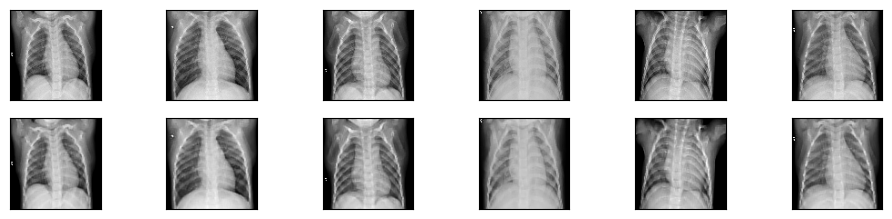

In [20]:
# plottig 1st six test samples and reconstructed images
plt.figure(figsize=(40,4))
for i in range(6):
    # original
    ax=plt.subplot(3,20,i+1+20)
    plt.imshow(x_test[i].reshape(100,100))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    #Reconstructed Image
    ax = plt.subplot(3, 20, 2*20 + i + 1)
    plt.imshow(predicted[i].reshape(100, 100))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
